# Likelihood Fit with Scipy
 >__Created__:  October 2021, Virtual, LPC Course: Statistics in Particle Physics.<br>
 >__Updated__: May 2022, INFN School of Statistics, Paestum, Italy
 
 
 This notebook gives a basic introduction to __Python__ and likelihood fits using __scipy__. It is an implementation of part of Glen Cowan's exercise at INFN SOS 2013, Vietri sul Mare, Italy. 
 
 ### Python Tips
  * Python uses indentation to create program blocks.
    Semicolons are not needed as in C++. It is therefore convenient to use
    a Python-aware editor, such as __emacs__. This will help
    minimize indentation errors.

  * There are two basic ways to load program modules into memory, e.g.:
```python
    import numpy
```
or
```python
    import numpy as np
```
and
```python
    from numpy import random
```
  * Strings can be initialized either with single or double quotes,
    'ABC' or "ABC". This is useful when "ABC" needs to be embedded within
    a string. Use \ to continue strings across lines: 
```python
    poem = 'You blocks you stones\n'\
           'You worse than senseless things'
```
  * *IMPORTANT*: Python uses __dynamic typing__, which means that the type of
    a variable is detemined at runtime by its value. Consequently,
    a variable's type is, well, variable!
```python
    x = 0     # x is an integer
    
    x = 0.0   # x is now a float
    
    x ='0'    # x is now a string
```
    Also (if you're still using Python 2) beware of
```python
    x = 42
    
    y = x / 84
```
The answer will be y = 0 because x is an integer!


In [1]:
# standard system modules
import os, sys

# standard table manipulation module
import pandas as pd

# standard array manipulation module
import numpy as np

# standard scientific python module
import scipy as sp
import scipy.stats as st
import scipy.optimize as op

# standard symbolic algebra pakage
import sympy as sm

# standard plotting module
import matplotlib as mp
import matplotlib.pyplot as plt

# make plots appear inline
%matplotlib inline

In [2]:
# update fonts
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20
        }
mp.rc('font', **font)
mp.rc('xtick', labelsize='x-small')
mp.rc('ytick', labelsize='x-small')

# set usetex = False if Latex is not available on your system
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility 
# on a given machine
seed = 111
rnd = np.random.RandomState(seed)

### Generate some data from an exponential

In [3]:
scale =  10.0
ndata = 200
data  = scale * rnd.standard_exponential(ndata)
data[:4]

array([ 9.47188633,  1.85209428,  5.72805677, 14.66474459])

### Plot data as a histogram

In [6]:
def plotData(data, nbins, 
             xmin=0, xmax=50,
             ymin=0, ymax=60,
             ftsize=20, 
             color=(0,0,1), 
             fgsize=(8,5)):

    # set size of figure
    plt.figure(figsize=fgsize)
    
    # histogram data
    # returns y, x, o
    # y: counts
    # x: bin boundaries
    # o: objects (not used, hence the use of "_")
    y, x, _ = plt.hist(data, 
                       bins=nbins, 
                       color=color,
                       alpha=0.3,
                       range=(xmin, xmax), 
                       density=False)
    
    # convert bin boundaries to bin centers
    # Note: x[1:]  = x[1], x[2], ..., x[n-1]
    #       x[:-1] = x[0], x[1], ..., x[n-2]
    x = (x[:-1]+x[1:])/2
    
    # add simple "error" bars sqrt(N)
    y_err = np.sqrt(y)
    
    plt.errorbar(x, y, yerr=y_err, 
                 fmt='o', 
                 ecolor='blue', 
                 markersize=10,
                 color='steelblue')

    # add legends in the order in which plot objects
    # are created
    plt.legend(['data'])
    
    # set up x, y limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    # add x and y labels
    plt.xlabel('$x$', fontsize=24)
    plt.ylabel('counts', fontsize=24)
    
    # tighten layout so that image is fully
    # contained within viewport
    plt.tight_layout()
    plt.savefig("fig_likelihood_data.pdf")
    plt.show()
    
    # convert lists to numpy arrays
    return (np.array(x), np.array(y))

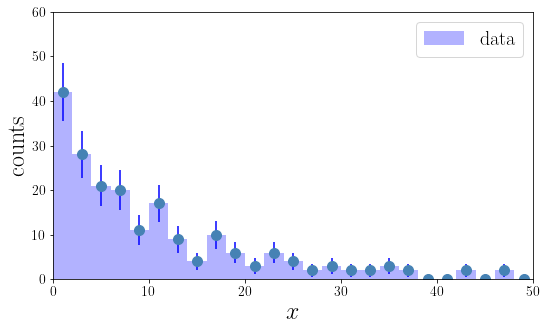

In [7]:
xx, yy = plotData(data, nbins=25, 
                  xmin=0, xmax=50,
                  ymin=0, ymax=60)

# bin width
h = xx[1]-xx[0]

### Exclude bins with a count less than 5
Note use of __zip__ to zip together two lists __xx__ and __yy__ to form a list  __dd__ of 2-tuples and use __zip(*dd)__ to unzip.

In [8]:
# exclude bins with a count of zero
select = yy > 5
x = xx[select]
y = yy[select]
m = len(x)
print("number of data points with more than 5 counts: %d" % m)

number of data points with more than 5 counts: 10


In [25]:
mu = 1
k  = 2
y0 = -2*(-mu + k*np.log(mu) - np.log(np.math.factorial(k)))
y1 = -2*st.poisson.logpmf(k, mu)
y1,y0

(3.386294361119891, 3.386294361119891)

### Fit model $\color{blue}{a b \exp(-b x)}$ to data
The __scipy__ function
```python
results = op.least_squares(func, guess, bounds=[lower, upper])
```
where
  * *func* is an $m$-dimensional real function $f_i(\theta)$, $i = 1, \cdots, m,$ with an $n$-dimensional parameter vector $\theta$;
  * *guess* is an initial estimate of the parameter vector $\theta$, and
  * *bounds* contain the lower and upper bounds on the parameter space to be searched,
  
by default, minimizes the function
$$C(\theta) = \frac{1}{2} \sum_{i=1}^m f_i^2(\theta) .$$

We set 
$$f_i(\theta) = 2 \sqrt{-[\log \text{Poisson}(N_i, y_i) - \log \text{Poisson}(N_i, N_i)]}$$
so
that
$$C(\theta) = - 2 \sum_{i=1}^m [\log \text{Poisson}(N_i, y_i) - \log \text{Poisson}(N_i, N_i)],$$
where $y_i(\theta) = a b \int_\textrm{bin$_i$} \exp(-b x) \, dx \approx a b \exp(-b x_i) \times h$, with $\theta = a, b$ and $h$ is the bin width. For large $N$, we expect the density of $C$ to be approximately $p(\chi^2, \textrm{ndf})$ with $\textrm{ndf} = m - n$ degrees of freedom (since there are $m$ bins and $n=2$ free parameters).

### Covariance matrix
If $C(\theta)$ is approximately a $\chi^2$ variate, then the covariance matrix of the parameters can be approximated by $\text{Cov} = H^{-1}$, where 
the Hessian matrix $H$ is given by

$
\begin{align*}
    H_{jk} &= \frac{\partial^2 C}{\partial \theta_j \partial \theta_k},\\
    & = 
\sum_{i=1}^{m} \frac{\partial f_i}{\partial \theta_j} \frac{\partial f_i}{\partial \theta_k}  + \sum_{i=1}^{m} f_i \, \frac{\partial^2 f_i}{\partial \theta_j \partial \theta_k} , 
\end{align*}
$

and evaluated at the best-fit value $\theta = \hat{\theta}$.

#### Results
The data structure __results__ contains
  * results.x: the fitted parameter values
  * results.cost: $C_\textrm{min}(\theta)$
  * results.jac: the $m \times n$ Jacobian matrix $J_{ij} = [\partial f_i / \partial \theta_j]$ from which the Hessian can be approximated by $H \approx J^T J$.

### Define model to be fitted to data

In [27]:
def func(params, *args):
    x, n, h = args
    a, b = params
    mu= a * b * np.exp(-b*x) * h
    f = -st.poisson.logpmf(n, mu) + st.poisson.logpmf(n, n)
    return 2*np.sqrt(f)

### Perform least squares fit

In [28]:
guess = [50.0, 5.0]    # estimates of a and b
lower = [0.0, 0.0]     # lower bounds of a and b
upper = [500.0, 500.0] # upper bounds of a and b


results = op.least_squares(func, guess, 
                           args=(x, y, h),
                           bounds=[lower, upper])

### Get results of fit

In [29]:
# best-fit parameters
a, b  = results.x

# compute approximate covariance matrix
J     = results.jac
H     = np.dot(J.T, J)   # approximate Hessian
cov   = np.linalg.inv(H)

# get approximate standard "errors"
da    = np.sqrt(cov[0][0])
db    = np.sqrt(cov[1][1])

chisq = results.cost     # minimum chisquare
NDF   = m - 2            # number of degrees of freedom
chisqNDF = chisq/NDF
print('''
a = %6.2f +/- %5.2f
b = %6.2f +/- %5.2f
chisq / NDF = %5.2f / %d = %5.2f
''' % (a, da, b, db, chisq, NDF, chisqNDF))


a = 206.62 +/- 13.21
b =   0.09 +/-  0.01
chisq / NDF =  6.19 / 8 =  0.77



## A bit of statistics

A fit of a model to data returns estimates $\hat{\theta}$ of the model parameters $\theta$, a measure of the uncertainty associated with these estimates, and,
ideally, a measure of how well the model fits the data. In the frequentist approach this measure is referred to as a 
    __goodness of fit__ (gof). 

Goodness of fit is an example of an __hypothesis test__ in which, unlike the Neyman-Pearson and Bayesian approaches, an alternative hypothesis is not explicitly specified. The single-hypothesis approach was introduced by the British statistician Sir Ronald Fisher in the 1930s. In this problem the  hypothesis being tested, denoted by $H_0$, is that the *fit of the model to the data is good*.   In Fisher's approach one tests the hypothesis $H_0$, called the __null hypothesis__, by asking whether it should be *rejected*. 

Fisher proposed the following procedure: construct a statistic $S$ with the property that a value equal to or greater than the observed value, $S_0$, of the statistic $S$ would cast doubt on the veracity of the null hypothesis, $H_0$. Then, assuming that the null hypothesis is true, one computes the probability

$$p = \text{Prob}(S \geq S_0).$$

The probability $p$ is called a __p-value__. If the p-value is very small then either the null hypothesis is true and a rare fluctuation has been observed or the null hypothesis is false. If the p-value is judged to be unreasonably small one might be inclined to reject the null hypothesis and act as if it is false.

For this problem, we shall use the statistic

  $$S(\theta) = \sum_{i=1}^M \left(\frac{N_i - n_i(\theta)}{\sqrt{N_i}}\right)^2 ,$$
  
that is, the same function as the one we minimized and take $S_0 = S(\hat{\theta})$ as its observed value. The reason this statistic is convenient is that it is approximately a $\chi^2$ variate of $m - n$ degrees of freedom; therefore, its probability density is known and, crucially, does not depend on the *unknown* value of the parameter vector $\theta$. Furthermore, values $S_0 >> m - n$ would cast doubt on the hypothesis that the fit is good. Consequently, the p-value is given by

$$\text{p-value} = \int_{S_0}^{\infty} p(\chi^2) \, d\chi^2.$$

In [30]:
pvalue = 1 - st.chi2.cdf(chisq, NDF)
print('''
p-value of fit: %6.2f
''' % pvalue)


p-value of fit:   0.63



Since the p-value is large, we have no reason to reject the hypothesis that the fit is good.

### Plot results of fit

In [34]:
def plotResult(x, y, params, nbins=25, 
               xmin=0, xmax=50, 
               ymin=0, ymax=60, 
               ftsize=20, 
               color=(0,0,1), 
               fgsize=(8, 5)):
    a, b = params
    
    # set size of figure
    plt.figure(figsize=fgsize)
    
    # plot points with simple error bars sqrt(N)
    y_err = [np.sqrt(z) for z in y]
    plt.errorbar(x, y, yerr=y_err, fmt='o', 
                 ecolor='blue', markersize=10,
                 color='steelblue')
    
    h = x[1]-x[0]
    f = a*b*np.exp(-b*x)*h
    plt.plot(x, f, 'r-')
    
    # add legends in order in which plot objects
    # are created
    plt.legend(['fit', 'data'])
    
    # set up x, y limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
   
    # add x and y labels
    plt.xlabel('$x$', fontsize=ftsize)
    plt.ylabel('counts', fontsize=ftsize)
    
    # annotate 
    xwid = (xmax-xmin)/10
    ywid = (ymax-ymin)/10

    xpos = 3*xwid
    ypos = 9*ywid
    
    plt.text(xpos, ypos, 
             r'$g(x, \theta) = a b \exp(-b x)$', fontsize=ftsize)
    
    ypos -= ywid*2
    plt.text(xpos, ypos, 
             r'$a = %6.1f \pm %5.1f$' % (a, da), fontsize=ftsize)
    
    ypos -= ywid
    plt.text(xpos, ypos, 
             r'$b = %6.2f \pm %5.2f$' % (b, db), fontsize=ftsize)
    
    ypos -= ywid
    plt.text(xpos, ypos, 
             r'$\chi^2 \, /\,$ NDF $= %6.1f \, / \, %d$' % (chisq, NDF), 
             fontsize=ftsize)

    ypos -= ywid
    plt.text(xpos, ypos, 
             r'$p$-value = %6.2f' % pvalue, 
             fontsize=ftsize)
 
    # tighten layout so that image is fully
    # contained within viewport
    plt.tight_layout()
    plt.savefig("fig_likelihood_fit.pdf")
    plt.show()

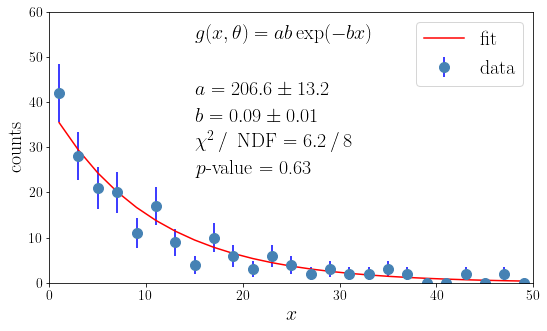

In [32]:
plotResult(xx, yy, results.x, 
           nbins=25, xmin=0, xmax=50, ymin=0, ymax=60)